<a href="https://colab.research.google.com/github/Balaji2196/traffic_sign_detection/blob/master/traffic_sign_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing the traffic sign dataset from bit bucket

In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


#List of files in the german_traffic_signs folder

In [2]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


#Importing Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2

#Loading Pickle files and splitting the data features and labels

In [25]:
np.random.seed(0)

#loading the train.p pickle file
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)

#loading the valid.p pickle file
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)

# loading the test.p pickle file
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)
     
        
# Splitting out features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
     
print("The dimensions of x_train is:",X_train.shape)
print("The dimensions of x_test is:",X_test.shape)
print("The dimensions of x_val is:",X_val.shape)

  

The dimensions of x_train is: (34799, 32, 32, 3)
The dimensions of x_test is: (12630, 32, 32, 3)
The dimensions of x_val is: (4410, 32, 32, 3)


#visualizing the traffic signs with their class names 

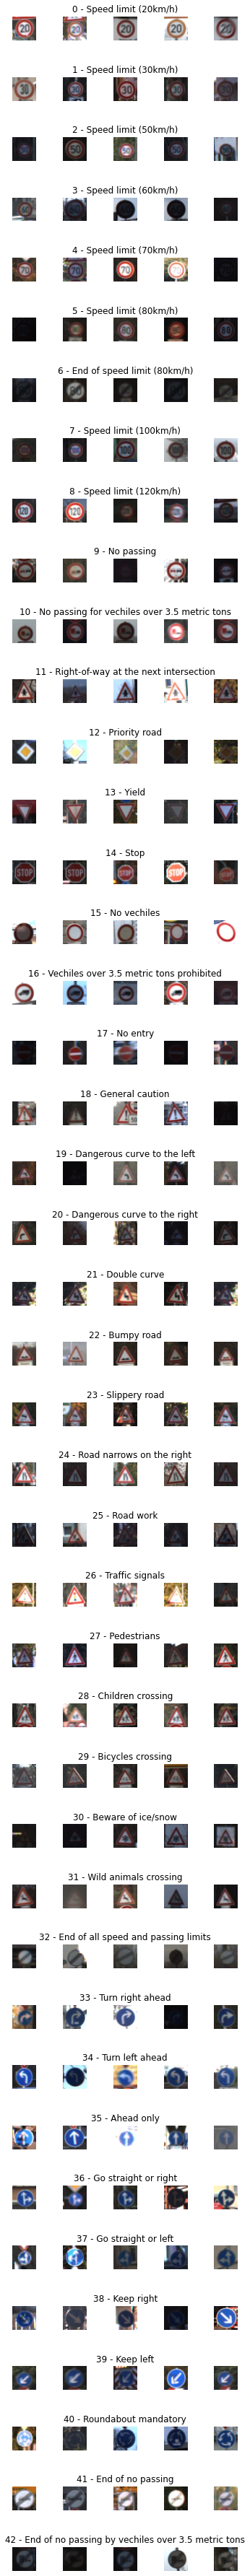

In [5]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
      
num_of_samples=[]
     
cols = 5
num_classes = 43
     
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
     
for i in range(cols):
  for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
           axs[j][i].set_title(str(j) + " - " + row["SignName"])
           num_of_samples.append(len(x_selected))

#visualizing the distribution of signs in each class on bar chart

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


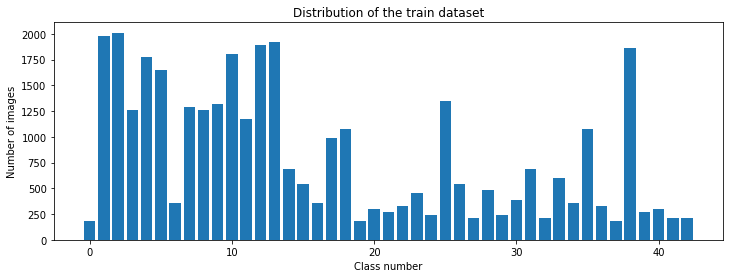

In [6]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

#Data preprocessing

(32, 32, 3)
36


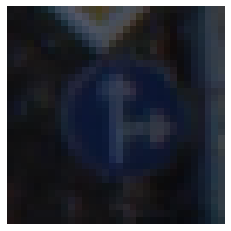

In [29]:
import cv2
     
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

(32, 32)
(32, 32)


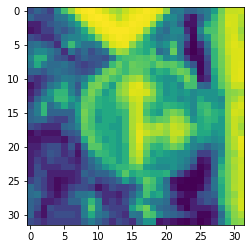

In [31]:
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

#Preprocessing X_train,X_test,X_val data

(34799, 32, 32)


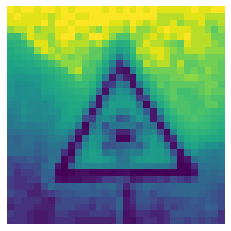

In [32]:
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))
     
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)



#Reshaping the preprocessed data

In [34]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

#Data Augmentation

(15, 32, 32, 1)


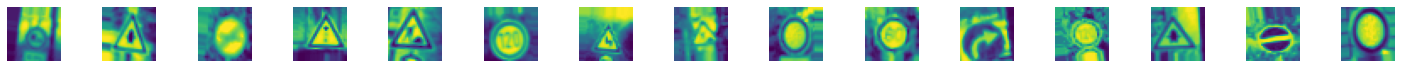

In [35]:
from keras.preprocessing.image import ImageDataGenerator
     
datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)
     
datagen.fit(X_train)


batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)
     
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
     
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
     
print("the X_batch shape is:",X_batch.shape)

#Encoding the Labels and creating the model

In [12]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

# create model
     
def modified_model():
   model = Sequential()
   model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
   model.add(Conv2D(60, (5, 5), activation='relu'))
   model.add(Conv2D(60, (5, 5), activation='relu'))
   model.add(MaxPooling2D(pool_size=(2, 2)))
   model.add(Conv2D(30, (3, 3), activation='relu')) 
   model.add(Conv2D(30, (3, 3), activation='relu'))
   model.add(Conv2D(30, (3, 3), activation='relu'))
   model.add(MaxPooling2D(pool_size=(2, 2)))
      
   model.add(Flatten())
   model.add(Dense(500, activation='relu'))
   model.add(Dropout(0.5))
   model.add(Dense(43, activation='softmax'))
      
   model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
   return model

#Training the model and visualizing the model parameters

In [13]:
model = modified_model()
print(model.summary())
     
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                              steps_per_epoch=X_train.shape[0]/50,
                              epochs=10,
                              validation_data=(X_val, y_val), shuffle = 1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 30)          16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 30)          8130      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 30)          8

#Visualizing the loss and val_loss

Text(0.5, 0, 'epoch')

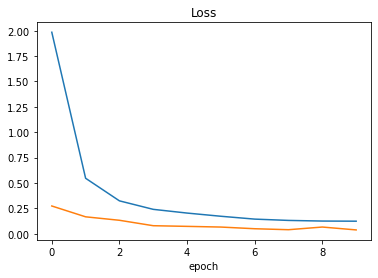

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

#Visualizing the training and test accuracy

Text(0.5, 0, 'epoch')

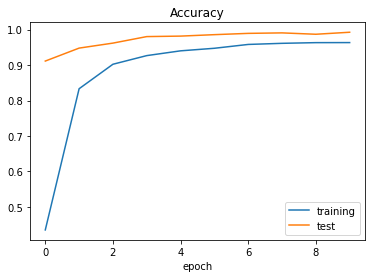

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [16]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.17172813415527344
Test accuracy: 0.9665083289146423


#Testing the model with single image

(32, 32)
predicted sign: [29]


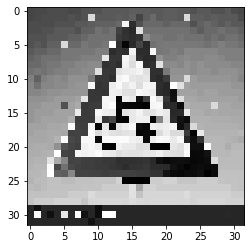

In [23]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)
 
print("predicted sign: "+ str(model.predict_classes(img)))